# Using a linear regression predictive model to predict number of available bikes 

The model estimated is a linear model taking the form:

𝑡𝑎𝑟𝑔𝑒𝑡_𝑓𝑒𝑎𝑡𝑢𝑟𝑒=𝑤0+𝑤1∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒1+𝑤2∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒2+...+𝑤𝑛∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒𝑛 

The target feature is availableBikes

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pickle
import pandas as pd
import matplotlib.pyplot as plt

### Import functions from "functions.ipynb"

In [2]:
%run functions.ipynb

### Get lists from "data_prep.ipynb"
**To load the %stored variables run the cells in data_prep.ipynb first**

In [4]:
%store -r all_features
# all_features

In [5]:
%store -r station_id_list full_hour_list weekdays_list

### Loading dataframe from pickle file
**Before running the following cells create pickle file by runnning data-prep.ipynb**

In [6]:
filename = 'df_station_updates_all_features'
infile = open(filename,'rb')
df_station_updates_all_features = pickle.load(infile)
infile.close()

In [7]:
print(type(df_station_updates_all_features))

<class 'pandas.core.frame.DataFrame'>


In [8]:
df_station_updates_all_features.head()

,stationId,totalStands,availableBikes,freeStands,lastUpdate,temperature,cloudiness,windSpeed,rain,snow,...,mainWeather_Fog,mainWeather_Mist,mainWeather_Rain,mainWeather_Snow,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2,20,10,10,2021-02-27 17:35:14,9.34,75.0,2.57,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,2,20,10,10,2021-02-27 17:45:23,9.20,75.0,1.03,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,2,20,10,10,2021-02-27 17:55:32,9.48,75.0,1.03,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,2,20,11,9,2021-02-27 18:00:42,9.22,75.0,1.03,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,2,20,11,9,2021-02-27 18:10:51,8.85,75.0,0.51,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [9]:
df_station_updates_all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586132 entries, 0 to 586131
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   stationId            586132 non-null  object        
 1   totalStands          586132 non-null  int64         
 2   availableBikes       586132 non-null  int64         
 3   freeStands           586132 non-null  int64         
 4   lastUpdate           586132 non-null  datetime64[ns]
 5   temperature          586132 non-null  float64       
 6   cloudiness           586132 non-null  float64       
 7   windSpeed            586132 non-null  float64       
 8   rain                 586132 non-null  float64       
 9   snow                 586132 non-null  float64       
 10  fullHour             586132 non-null  int64         
 11  hour_sin             586132 non-null  float64       
 12  hour_cos             586132 non-null  float64       
 13  mainWeather_Cl

### Training models with multiple linear regression

In [10]:
# this function fits a linear regression model to the training data
# returns the model learned
def apply_model_to_training_data(X_training_data, y_training_data):
    model = LinearRegression().fit(X_training_data, y_training_data)
    return model

In [11]:
def train_model_per_station(df, station_id_list, features, number_splits, number_test_size, number_gap):
   
    # initialise a dict that will store the station models for each split for all stations
    stations_splits_and_models = {}
    for station_id in station_id_list:
        # create a key with each station Id and assign another dict as a value that will hold the features, splits, and models learned
        stations_splits_and_models[station_id] = {'Features': features}

        # get rows with stationId == station_id separated by descriptive features and target feature
        df_station_data = filter_station_data(df, station_id)

        # get station data ordered by lastUpdate to make sure data is sequential timewise
        df_station_time_ordered = order_df_by_lastUpdate(df_station_data)

        # separate descriptive features from target feature
        X, y = get_station_features_and_target(df_station_time_ordered, features)

        # split data into test and training data using TimeSeriesSplit and train the model for each split     
        splits = split_time_series_data_and_train_model_for_each_split(X, y, number_splits, number_test_size, number_gap)

        for key in splits.keys():
            stations_splits_and_models[station_id][key] = {}

            split_coeficients = splits[key]['Model'].coef_.tolist()
            split_intercept = splits[key]['Model'].intercept_
            split_model = splits[key]['Model']
            split_X_train = splits[key]['X_train']
            split_X_test = splits[key]['X_test']
            split_y_train = splits[key]['y_train']
            split_y_test = splits[key]['y_test']
            
            # store data in each split
            stations_splits_and_models[station_id][key]['X_train'] = split_X_train
            stations_splits_and_models[station_id][key]['X_test'] = split_X_test
            stations_splits_and_models[station_id][key]['y_train'] = split_y_train
            stations_splits_and_models[station_id][key]['y_test'] = split_y_test
            
            # store model learned for each split for the current station in 'stations_splits_and_models' dict
            stations_splits_and_models[station_id][key]['Coeficients'] = split_coeficients
            stations_splits_and_models[station_id][key]['Intercept'] = split_intercept
            stations_splits_and_models[station_id][key]['Model'] = split_model
                                                         
    # return features, splits data and all models learned for each split for every station in a dict
    return stations_splits_and_models

In [12]:
stations_splits_and_models = train_model_per_station(df_station_updates_all_features, station_id_list, all_features, number_splits=4, number_test_size=None, number_gap=0)

In [13]:
# this dict has the features, splits and models learned for each split for every station
stations_splits_and_models[2].keys()

dict_keys(['Features', 'split_1', 'split_2', 'split_3', 'split_4'])

### Predictions (for each split) for every station

In [14]:
# get predicted availability values and metrics on training data for all stations for each data split
predictions_training_data = get_predictions_and_metrics_for_each_split_all_stations(stations_splits_and_models, 'X_train', 'y_train')
# this dict has the predictions for each station for each train data split, the metrics per split
    # and the avg across all splits
predictions_training_data[2].keys() 

dict_keys(['split_1', 'split_2', 'split_3', 'split_4', 'AVG Metrics'])

In [15]:
# get predicted availability values and metrics on test data for all stations for each data split
predictions_test_data = get_predictions_and_metrics_for_each_split_all_stations(stations_splits_and_models, 'X_test', 'y_test')
# this dict has the predictions for each station for each test data split, the metrics per split
    # and the avg across all splits
len(predictions_test_data)

109

### Metrics (for each split and the average over all splits) for every station

In [16]:
predictions_test_data[2]['AVG Metrics']

{'AVG MAE': 4.733092700932025,
 'AVG MSE': 33.34095291521121,
 'AVG RMSE': 5.692179068788941,
 'AVG R2': -0.998466041978683}

#### Average RMSE across Stations

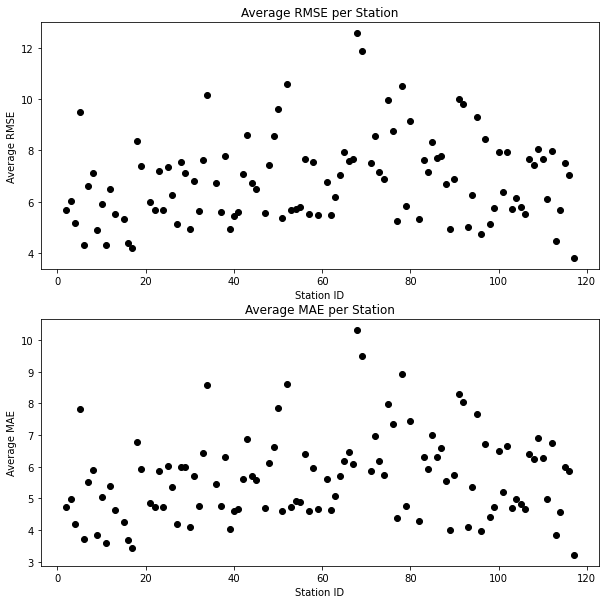

<Figure size 720x720 with 0 Axes>

In [17]:
rmse = []
mae = []

for s in station_id_list:
    rmse.append(predictions_test_data[s]['AVG Metrics']['AVG RMSE'])
    mae.append(predictions_test_data[s]['AVG Metrics']['AVG MAE'])

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
plt.figure(figsize=(10,10))
ax1.set_title("Average RMSE per Station")
ax1.set_ylabel("Average RMSE")
ax1.set_xlabel("Station ID")
ax1.plot(station_id_list, rmse, 'o', color='black');

ax2.set_title("Average MAE per Station")
ax2.plot(station_id_list, mae, 'o', color='black')
ax2.set_xlabel("Station ID")
ax2.set_ylabel("Average MAE")
fig.savefig("Average RMSE and MAE");

In [18]:
pd.DataFrame({'station_id': station_id_list, 'rmse': rmse, 'mae': mae}).describe()[['rmse', 'mae']]

,rmse,mae
count,109.000000,109.000000
mean,6.861249,5.671253
std,1.680435,1.357195
min,3.799913,3.229664
25%,5.609239,4.705680
50%,6.729142,5.614813
75%,7.680632,6.391831
max,12.556212,10.321259
